# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

• Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
• Контролировать добросовестность кассиров при продаже алкоголя.  

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Загрузим необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

Загрузим данные

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Оценим структуру данных таблицы labels, посмотрим на размер выборки

In [ ]:
display('Структура данных таблицы labels')
display(labels.info())
display('Характерные значения таблицы labels', labels.describe().T)
display(labels.head(15).T)

'Структура данных таблицы labels'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

'Характерные значения таблицы labels'

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
file_name,000000.jpg,000001.jpg,000002.jpg,000003.jpg,000004.jpg,000005.jpg,000006.jpg,000007.jpg,000008.jpg,000009.jpg,000010.jpg,000011.jpg,000012.jpg,000013.jpg,000014.jpg
real_age,4,18,80,50,17,27,24,43,26,39,17,51,2,1,6


Определим количество дублей

In [ ]:
print('Количество дублей', labels.duplicated().sum())

Количество дублей 0


Построим гистограмму и график плотности распределения поля real_age

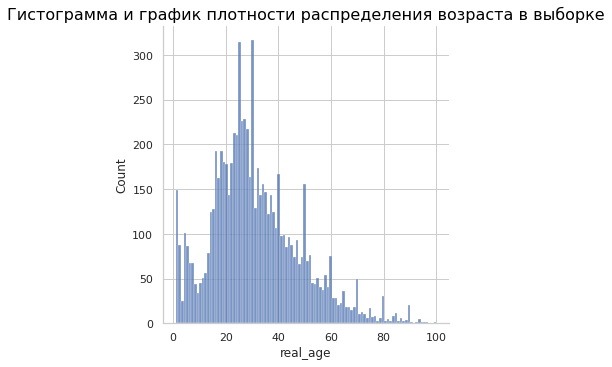

In [ ]:
sns.displot(labels['real_age'], bins=100)
plt.xlabel('real_age')
plt.title('Гистограмма и график плотности распределения возраста в выборке', loc='center', fontsize=16, fontweight=0, color='black');

Вывод:
- График похож на нормальное распределение. Среднее значение поля **real_age** `31` практически равно медиане `29`
- Видна небольшая бимодальность. Скорее всего, как минимум, замешана ещё одна выборка в данных. Т.е. есть некий признак, который делает гарфик двугорбым. Например школьники и остальные. Т.е. выборка была взята не случайна, а формировалась.
- Пожилых мало - это значит модель плохо обучится

Выведем на экран 15 фотографий

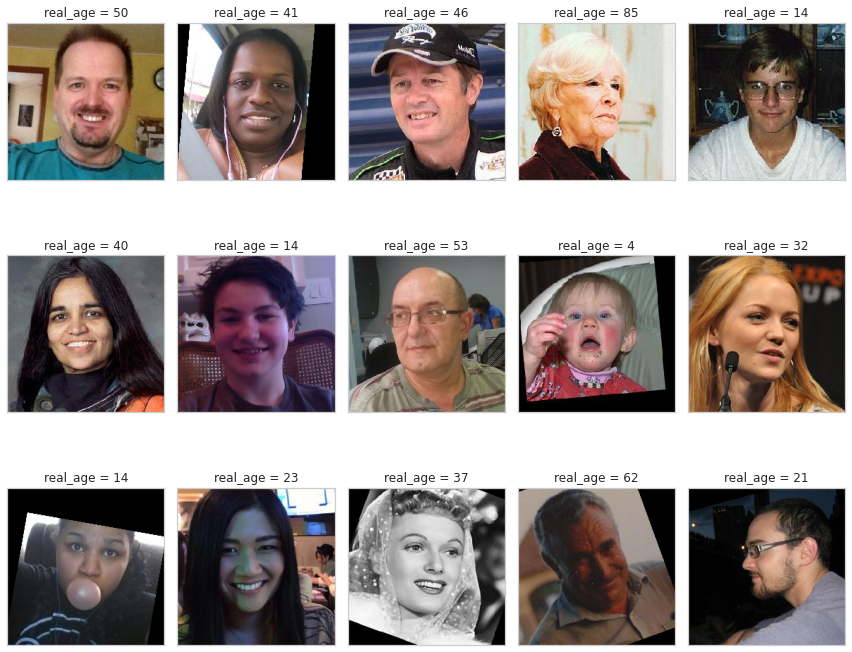

In [ ]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(12,12))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title('real_age = {}'.format(target[i]))
    # для компактности удалим оси и прижмем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод:  
Датасет содержит 7591 размеченных изображений.
Таблица **labels.csv** состоит из `7591` строк и `2` столбцов:

- **file_name** — название файла с изображением человека (тип - `object`)
- **real_age** — количество лет (тип - `int64`)  


Пропуски и дубли отсутствуют. Выбросов также не обнаружено.

В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев (нету в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость.  

В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона.  

В датасете есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев.  

В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

labels = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/20
2023-03-05 23:01:19.841252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-05 23:01:20.189048: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 54s - loss: 188.1303 - mae: 10.1776 - val_loss: 765.3191 - val_mae: 22.7253
Epoch 2/20
356/356 - 45s - loss: 83.9340 - mae: 6.9178 - val_loss: 147.3135 - val_mae: 8.9577
Epoch 3/20
356/356 - 45s - loss: 56.5247 - mae: 5.7589 - val_loss: 85.7297 - val_mae: 6.9688
Epoch 4/20
356/356 - 46s - loss: 40.2475 - mae: 4.8498 - val_loss: 71.6179 - val_mae: 6.3466
Epoch 5/20
356/356 - 45s - loss: 31.3144 - mae: 4.2640 - val_loss: 77.4257 - val_mae: 6.5793
Epoch 6/20
356/356 - 44s - loss: 25.1680 - mae: 3.8254 - val_loss: 68.2349 - val_mae: 6.1832
Epoch 7/20
356/356 - 45s - loss: 20.5779 - mae: 3.4709 - val_loss: 75.2879 - val_mae: 6.5645
Epoch 8/20
356/356 - 45s - loss: 16.7850 - mae: 3.1272 - val_loss: 67.6520 - val_mae: 6.1994
Epoch 9/20
356/356 - 45s - loss: 13.6974 - mae: 2.8337 - val_loss: 65.0886 - val_mae: 5.9283
Epoch 10/20
356/356 - 44s - loss: 13.2351 - mae: 2.7731 - val_loss: 71.3290 - val_mae: 6.2639
Epoch 11/20
356/356 - 45s - loss: 12.4003 - mae: 2.6688 - val_loss: 64.4243 - val_mae: 5.9912
Epoch 12/20
356/356 - 44s - loss: 10.9673 - mae: 2.5336 - val_loss: 62.4239 - val_mae: 5.8850
Epoch 13/20
356/356 - 45s - loss: 11.3038 - mae: 2.5718 - val_loss: 94.4594 - val_mae: 7.3214
Epoch 14/20
356/356 - 45s - loss: 11.6012 - mae: 2.6023 - val_loss: 62.3092 - val_mae: 5.8316
Epoch 15/20
356/356 - 41s - loss: 11.5780 - mae: 2.5689 - val_loss: 66.1576 - val_mae: 6.1266
Epoch 16/20
356/356 - 41s - loss: 10.7633 - mae: 2.4764 - val_loss: 65.6950 - val_mae: 6.1468
Epoch 17/20
356/356 - 41s - loss: 9.7025 - mae: 2.3743 - val_loss: 63.8354 - val_mae: 6.1370
Epoch 18/20
356/356 - 41s - loss: 9.2060 - mae: 2.3124 - val_loss: 61.0597 - val_mae: 5.8134
Epoch 19/20
356/356 - 42s - loss: 9.1486 - mae: 2.2739 - val_loss: 62.6795 - val_mae: 5.8787
Epoch 20/20
356/356 - 41s - loss: 8.5092 - mae: 2.2022 - val_loss: 62.6370 - val_mae: 5.8444

119/119 - 10s - loss: 62.6370 - mae: 5.8444
Test MAE: 5.8444

```

## Анализ обученной модели

Вывод:  

- В ходе выполнения задания была построена и обучена модель, которая по фотографии определяет приблизительный возраст человека.
- Для обучения использована нейронная сеть ResNett50.  
- Обучение проходило на 10 эпохах.  
- Функция потерь MAE на тестовой выборке составила 5.8444 (learning rate = 0.0001). По заданию, небоходимо было добиться значения MAE на тестовой выборке не больше 8. Задача выполнена.